# Plot all dvv traces with model fit

2023.4.28 Kurama Okubo

Plot all dvv data with models. We sort the data with fault normal distance to identify the cause of propotional increase in S2 and decrease in tmax2.
This notebook is originally from `modelfit_06_MCMC_computemodelstats.ipynb`.

2023.06.30 update to count the excluded station pairs. Debug the missing station pairs associated with the stretching.

In [1]:
# %load_ext autoreload
# %autoreload 2

import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import display, Math
import seaborn as sns 

import numpy as np
import pandas as pd
import h5py
import pickle

import shutil
from tqdm import tqdm
import glob

import matplotlib as mpl

import emcee # MCMC sampler
import corner

# import mcmc functions
from scattermatrix import *
from MCMC_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

# Plot all dv/v fitting time history

In [2]:
# load the data
dvvmethod = "mwcs"
modelcase = "wlin"

modelparam_indir = "../modelparam_data"
freqband = "0.9-1.2"

residu_absmean_thresh = 0.05
residu_var_thresh = 0.002

outputdatadir = "../data_stats"
output_imgdir = "../figure_stats"

if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)
    
if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)


In [3]:
# search the modelparam files
fi_list = np.sort(glob.glob(modelparam_indir+f"/MCMC_modelparam_*_{dvvmethod}_{freqband}Hz_{modelcase}.pickle"))

In [4]:
# check overlap between the cases with stretching and mwcs
fi_list_stretching = np.sort(glob.glob(modelparam_indir+f"/MCMC_modelparam_*_stretching_{freqband}Hz_{modelcase}.pickle"))
fi_list_mwcs = np.sort(glob.glob(modelparam_indir+f"/MCMC_modelparam_*_mwcs_{freqband}Hz_{modelcase}.pickle"))

stationpair_stretching_intersect = []
stationpair_mwcs = []
for finame in fi_list_stretching:
    stationpair = os.path.basename(finame).split("_")[2]
    stationpair_stretching_intersect.append(stationpair)

for finame in fi_list_mwcs:
    stationpair = os.path.basename(finame).split("_")[2]
    stationpair_mwcs.append(stationpair)
    
for pair in stationpair_mwcs:
    try:
        stationpair_stretching_intersect.remove(pair)
    except ValueError:
#         print(f'skip {pair}')
        continue

print(f"The station pairs in the stretching but not in MWCS is {stationpair_stretching_intersect}")

The station pairs in the stretching but not in MWCS is ['BP.CCRB-BP.FROB', 'BP.JCNB-BP.LCCB', 'BP.JCNB-BP.MMNB']


In [5]:
meta_dict = dict()
dvv_dict = dict()

# store meta data
meta_dict["dvvmethod"] = dvvmethod
meta_dict["modelcase"] = modelcase
meta_dict["freqband"] = freqband

if meta_dict["modelcase"] == "base":
    meta_dict["ndim"] = 12
elif meta_dict["modelcase"] == "wlin":
    meta_dict["ndim"] = 13
else:
    print("model case not known.")
    
meta_dict["modelkeys"] = get_keys(meta_dict["modelcase"])
# read metadata

finame_meta = fi_list[0]
with open(finame_meta, 'rb') as fi:
    modelparam = pickle.load(fi)
    meta_dict["unix_tvec"] = modelparam["unix_tvec"]
    meta_dict["uniform_tvec"] = modelparam["uniform_tvec"]
    meta_dict["fitting_period_ind"] = modelparam["fitting_period_ind"]
    meta_dict["unix_tSS"] = modelparam["unix_tSS"]
    meta_dict["unix_tPF"] = modelparam["unix_tPF"]
    
meta_dict.keys()

dict_keys(['dvvmethod', 'modelcase', 'freqband', 'ndim', 'modelkeys', 'unix_tvec', 'uniform_tvec', 'fitting_period_ind', 'unix_tSS', 'unix_tPF'])

In [6]:
# read dv/v data and compute the model using best model parameters
stationpair_list=[]

for finame in fi_list:

    stationpair = os.path.basename(finame).split("_")[2]
    stationpair_list.append(stationpair)
    
    with open(finame, 'rb') as fi:
        modelparam_st = pickle.load(fi)
        
        # Reassemble maximum likelihood model paramters
        theta0 = modelparam_st["maxlnprob_theta"]
        if modelparam_st["fixparam01"] == True:
            # fix the aprecip, log10tmin1 and log10tmin2
            if  modelcase=="base":
                theta = np.concatenate((theta0[0:2], [modelparam_st["a_{precip}_fixed"]], theta0[2:5], [modelparam_st["log10tmin1_fixed"]],
                                  theta0[5:7], [modelparam_st["log10tmin2_fixed"]], theta0[7:9]), axis=None)
            elif modelcase=="wlin":
                theta = np.concatenate((theta0[0:2], [modelparam_st["a_{precip}_fixed"]], theta0[2:5], [modelparam_st["log10tmin1_fixed"]],
                                  theta0[5:7], [modelparam_st["log10tmin2_fixed"]], theta0[7:10]), axis=None)
        else:
            theta = theta0


        dvv_dict[stationpair+"/dvv_data"] = modelparam_st["dvv_data"]
        dvv_dict[stationpair+"/err_data"] = modelparam_st["err_data"]
        dvv_dict[stationpair+"/maxlnprob_theta"] = theta
        
        # compute the model
        if meta_dict["modelcase"] == "base":    
            model = model_base(theta, all=False, **modelparam_st)

        elif meta_dict["modelcase"] == "wlin":
            model = model_wlin(theta, all=False, **modelparam_st)

        dvv_dict[stationpair+"/dvv_model"] = model

In [7]:
# plt.plot(modelparam_st["uniform_tvec"], modelparam_st["precip"], "r-" )
# plt.plot(modelparam_st["uniform_tvec"], modelparam_st["CAVG"], "b-" )

# Compute residuals, AIC and BIC

In [8]:
# make a dataframe to store the model parameters and AIC, BIC
df_dvvstats_all = pd.DataFrame(columns=["dvvmethod", "modelcase", "freqband",  'a0', 'p1', 'a_{precip}', 'p2', 't_{shiftdays}',
                'S1', 'log10tmin1', 'log10tmax1', 'S2', 'log10tmin2','log10tmax2', 'b_{lin}', 'logf', 'AIC', 'BIC', 'residu_absmean', 'residu_var'])

for st in np.sort(stationpair_list):
    # st = stationpair_list[21]

    dvv_data = dvv_dict[st+"/dvv_data"]
    dvv_model = dvv_dict[st+"/dvv_model"]
    maxlnprob_theta = dvv_dict[st+"/maxlnprob_theta"]

    residu_absmean = np.nanmean(np.abs(dvv_model-dvv_data))
    residu_var = np.nanvar(dvv_model-dvv_data)

    # compute AIC and BIC
    AIC = compute_AIC(dvv_data*1e-2, dvv_model*1e-2, meta_dict["ndim"]) # convert from % to nondim
    BIC = compute_BIC(dvv_data*1e-2, dvv_model*1e-2, meta_dict["ndim"]) # convert from % to nondim

    stdict = {"dvvmethod":dvvmethod, "modelcase":modelcase, "freqband":freqband, "AIC": AIC, "BIC": BIC,
              "residu_absmean": residu_absmean, "residu_var": residu_var}
    
    # store model parameters
    for i, key in enumerate(meta_dict["modelkeys"]):
        stdict[key] = maxlnprob_theta[i]

    df_st = pd.DataFrame(stdict, index=[st])

    df_dvvstats_all = pd.concat([df_dvvstats_all, df_st])

    # plt.plot(dvv_data)
    # plt.plot(dvv_model)

In [9]:
df_dvvstats_all.to_csv(outputdatadir+"/MCMC_modelparam_all_{}_{}_{}.csv".format(dvvmethod, freqband, modelcase))

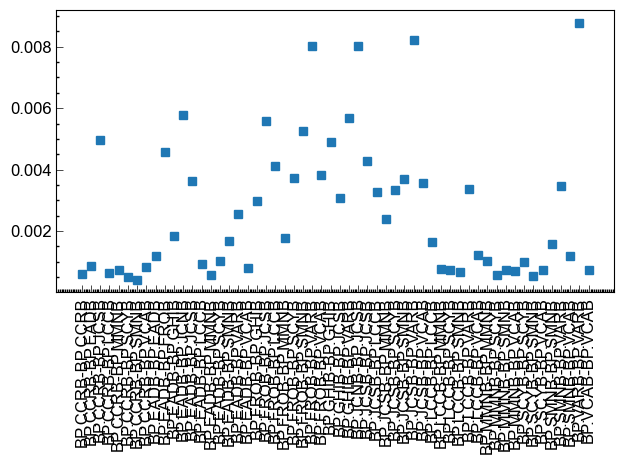

In [10]:
# plt.plot(df_dvvstats_all.residu_absmean, "o")
plt.plot(df_dvvstats_all.residu_var, "s")
plt.xticks(rotation = 90);
plt.tight_layout()

## Plot all the dvv model fit

We sort ACF by the station pair's name, and CCD by the variance.

In [11]:
if (dvvmethod=="mwcs") and (modelcase=="wlin") :
    # separate ACF
    station_ACF=[]
    for st in stationpair_list:
        st1, st2 = st.split("-")
        if st1==st2:
            station_ACF.append(st)

    station_ACF = np.sort(station_ACF)
    NACF = len(station_ACF)

    # CCF sorted by the variance
    station_CCF=[]
    for index, row in df_dvvstats_all.sort_values(by="residu_var", ascending=True).iterrows():
        st1, st2 = index.split("-")
        if st1 != st2:
            station_CCF.append(index)

    NCCF = len(station_CCF)

    # save the list of stations to synchronize with the stretching result
    stationpairs_dict={"station_ACF":station_ACF, "station_CCF":station_CCF}
    if dvvmethod=="mwcs":
        with open(outputdatadir+f'/plot_dvvmodel_listofstationpair_{freqband}_wlin.pickle', 'wb') as fo:
            pickle.dump(stationpairs_dict, fo)
            
else:
    try:
        with open(outputdatadir+f'/plot_dvvmodel_listofstationpair_{freqband}_wlin.pickle', 'rb') as fi:
            stationpairs_dict = pickle.load(fi)
    except:
        raise ValueError("Please run the case for the mwcs with linear term first to dump the station list.")
    
    station_ACF = stationpairs_dict["station_ACF"]
    station_CCF = stationpairs_dict["station_CCF"]
    NACF = len(station_ACF)
    NCCF = len(station_CCF)


In [12]:
stationpairs_dict

{'station_ACF': array(['BP.CCRB-BP.CCRB', 'BP.EADB-BP.EADB', 'BP.GHIB-BP.GHIB',
        'BP.JCSB-BP.JCSB', 'BP.LCCB-BP.LCCB', 'BP.MMNB-BP.MMNB',
        'BP.SCYB-BP.SCYB', 'BP.SMNB-BP.SMNB', 'BP.VARB-BP.VARB',
        'BP.VCAB-BP.VCAB'], dtype='<U15'),
 'station_CCF': ['BP.CCRB-BP.SMNB',
  'BP.CCRB-BP.SCYB',
  'BP.SCYB-BP.SMNB',
  'BP.EADB-BP.MMNB',
  'BP.MMNB-BP.SCYB',
  'BP.CCRB-BP.LCCB',
  'BP.LCCB-BP.SMNB',
  'BP.MMNB-BP.VCAB',
  'BP.CCRB-BP.MMNB',
  'BP.MMNB-BP.SMNB',
  'BP.LCCB-BP.SCYB',
  'BP.SCYB-BP.VCAB',
  'BP.LCCB-BP.MMNB',
  'BP.EADB-BP.VCAB',
  'BP.CCRB-BP.VCAB',
  'BP.CCRB-BP.EADB',
  'BP.EADB-BP.LCCB',
  'BP.EADB-BP.SCYB',
  'BP.SMNB-BP.VCAB',
  'BP.LCCB-BP.VCAB',
  'BP.EADB-BP.SMNB',
  'BP.FROB-BP.MMNB',
  'BP.EADB-BP.GHIB',
  'BP.JCSB-BP.MMNB',
  'BP.EADB-BP.VARB',
  'BP.FROB-BP.GHIB',
  'BP.GHIB-BP.JCSB',
  'BP.JCSB-BP.LCCB',
  'BP.JCSB-BP.SCYB',
  'BP.LCCB-BP.VARB',
  'BP.SMNB-BP.VARB',
  'BP.JCSB-BP.VCAB',
  'BP.EADB-BP.JCSB',
  'BP.JCSB-BP.SMNB',
  'BP.FROB-BP.SCYB

In [13]:
NACF, NCCF

(10, 46)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,10))

dvvmodel_IsOffsetRemoval = True
shift_y = 0.3
tSS = datetime.datetime(2003, 12, 22) # time for San Simeon
offset_ind = range(len(meta_dict["uniform_tvec"]))#np.where(np.array(meta_dict["uniform_tvec"]) < tSS)

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

ylimit=[-9.1, 0.2]


#--------------------------------#
# First half pairs
#--------------------------------#

# plot ACF
label_yticks_1 = []
label_yticklabels_1 = []
Nexcludedpair = 0
Nincludedpair = 0

for i, st in enumerate(station_ACF):
    try:
        dvv_data = dvv_dict[st+"/dvv_data"]
    except:
        Nexcludedpair = Nexcludedpair + 1
        continue
        
    dvv_model = dvv_dict[st+"/dvv_model"]

#     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
    if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:
        ls = ":"
    else:
        ls = "-"
    
    # remove offset
    if dvvmodel_IsOffsetRemoval:
        offset_data = np.nanmean(dvv_data[offset_ind])
        offset_model = np.nanmean(dvv_model[offset_ind])
        diff_offset = offset_model-offset_data
        dvv_data = dvv_data - offset_data
        dvv_model = dvv_model - offset_data #np.nanmean(dvv_model[offset_ind])    

    axs[0].plot(meta_dict["uniform_tvec"], dvv_data - i*shift_y, "k-", lw=1.0)
    axs[0].plot(meta_dict["uniform_tvec"], dvv_model - i*shift_y, "r", lw=1.0, ls=ls)
#     axs[0].axhline(-i*shift_y, c="k", ls="--", lw=1.0, zorder=-10)
#     axs[0].axhline(-i*shift_y + diff_offset, c="r", ls=":", lw=1.5, zorder=-10)

    label_yticks_1.append(- i*shift_y)
    # reformat the string
    netsta1, netsta2 = st.split("-")
    _, sta1 = netsta1.split('.')
    _, sta2 = netsta2.split('.')
    label_yticklabels_1.append(f"{sta1}-{sta2}")

# plot CCF
mNCCF = 30-NACF

for i, st in enumerate(station_CCF[:mNCCF]):
    try:
        dvv_data = dvv_dict[st+"/dvv_data"]
    except:
        Nexcludedpair = Nexcludedpair + 1
        continue;
        
    dvv_model = dvv_dict[st+"/dvv_model"]
    
#     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
    if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:

        ls = ":"
    else:
        ls = "-"
    
    # remove offset
    if dvvmodel_IsOffsetRemoval:
        offset_data = np.nanmean(dvv_data[offset_ind])
        offset_model = np.nanmean(dvv_model[offset_ind])
        diff_offset = offset_model-offset_data        
        dvv_data = dvv_data - offset_data #np.nanmean(dvv_data[offset_ind])    
        dvv_model = dvv_model - offset_data #np.nanmean(dvv_model[offset_ind])    

    axs[0].plot(meta_dict["uniform_tvec"], dvv_data - (i+NACF)*shift_y, "k-", lw=1.0)
    axs[0].plot(meta_dict["uniform_tvec"], dvv_model - (i+NACF)*shift_y, "r", lw=0.6,  ls=ls)
#     axs[0].axhline(-(i+NACF)*shift_y, c="k", ls="--", lw=1.0, zorder=-10)
#     axs[0].axhline(-(i+NACF)*shift_y + diff_offset, c="r", ls=":", lw=1.5, zorder=-10)

    label_yticks_1.append(-(i+NACF)*shift_y)
    # reformat the string
    netsta1, netsta2 = st.split("-")
    _, sta1 = netsta1.split('.')
    _, sta2 = netsta2.split('.')
    label_yticklabels_1.append(f"{sta1}-{sta2}")

#--------------------------------#
# second half pairs
#--------------------------------#
label_yticks_2 = []
label_yticklabels_2 = []

if dvvmethod == "stretching":
    # UPDATE: plot the staiton pairs not included in the case of MWCS
    stationCCF_secondhalf = station_CCF[mNCCF:] + stationpair_stretching_intersect
    Nincludedpair = Nincludedpair + len(stationpair_stretching_intersect)
else:
    stationCCF_secondhalf = station_CCF[mNCCF:] # MWCS
    
for i, st in enumerate(stationCCF_secondhalf):
    try:
        dvv_data = dvv_dict[st+"/dvv_data"]
    except:
        Nexcludedpair = Nexcludedpair + 1
        continue;
        
    dvv_model = dvv_dict[st+"/dvv_model"]
    
#     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
    if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:
        ls = ":"
    else:
        ls = "-"
    
    # remove offset
    if dvvmodel_IsOffsetRemoval:
        offset_data = np.nanmean(dvv_data[offset_ind])
        offset_model = np.nanmean(dvv_model[offset_ind])
        diff_offset = offset_model-offset_data 
        dvv_data = dvv_data - offset_data #np.nanmean(dvv_data[offset_ind])    
        dvv_model = dvv_model - offset_data #np.nanmean(dvv_model[offset_ind])    

    axs[1].plot(meta_dict["uniform_tvec"], dvv_data - (i+0)*shift_y, "k-", lw=1.0)
    axs[1].plot(meta_dict["uniform_tvec"], dvv_model - (i+0)*shift_y, "r", lw=0.6, ls=ls)
#     axs[1].axhline(-(i+0)*shift_y, c="k", ls="--", lw=1.0, zorder=-10)
#     axs[1].axhline(-i*shift_y + diff_offset, c="r", ls=":", lw=1.5, zorder=-10)

    label_yticks_2.append(-(i+0)*shift_y)
    # reformat the string
    netsta1, netsta2 = st.split("-")
    _, sta1 = netsta1.split('.')
    _, sta2 = netsta2.split('.')
    label_yticklabels_2.append(f"{sta1}-{sta2}")

axs[0].minorticks_off()
axs[0].set_yticks(label_yticks_1, labels=label_yticklabels_1)
# axs[0].set_yticklabels(label_yticklabels_1)
axs[0].xaxis.set_major_locator(mdates.YearLocator(2))
axs[0].xaxis.set_minor_locator(mdates.YearLocator(1))
axs[0].set_xlim(starttime, endtime)
axs[0].grid(True, which='major', axis='x', c="0.9")
axs[0].set_ylim(ylimit)


axs[1].minorticks_off()
axs[1].set_yticks(label_yticks_2, labels=label_yticklabels_2)
# axs[1].set_yticklabels(label_yticklabels_2)
axs[1].xaxis.set_major_locator(mdates.YearLocator(2))
axs[1].xaxis.set_minor_locator(mdates.YearLocator(1))
axs[1].set_xlim(starttime, endtime)
axs[1].grid(True, which='major', axis='x', c="0.9")
axs[1].set_ylim(ylimit)


fig.tight_layout()
fig.align_labels();


# plot scale
scale_x=datetime.datetime(2020,3,1)
scale_y = -8.99
scale_size = 0.1 #[%]

for i in range(2):
    axs[i].plot([scale_x, scale_x], [scale_y, scale_y + scale_size], ls ="-", c="k" )
    axs[i].text(scale_x+datetime.timedelta(days=60), scale_y + 0.5*scale_size, f"{scale_size}%", c="k" )


foname = (output_imgdir+"/MCMC_allldvvfit_{}_{}_{}.png".format(dvvmethod, freqband, modelcase))
plt.savefig(foname, dpi=300)

In [15]:
print(F"We excluded {Nexcludedpair} from {NACF+NCCF} pairs + {Nincludedpair} for {dvvmethod}. Total {NACF+NCCF-Nexcludedpair + Nincludedpair} pairs.") 

We excluded 0 from 56 pairs + 0 for mwcs. Total 56 pairs.


# Plot with sorting by fault normal distance

In [16]:
# read the sorted stations dumped in modelfit_07_MCMC_plotstats.ipynb
with open(outputdatadir+f'/plot_dvvmodel_sortedbydist_wlin_{freqband}_{dvvmethod}.pickle', 'rb') as fi:
    stationpairs_dict = pickle.load(fi)
    pairdist_dict = pickle.load(fi)

In [17]:
cpalette=np.array(sns.color_palette("dark"))

In [18]:
sns.color_palette("dark")

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

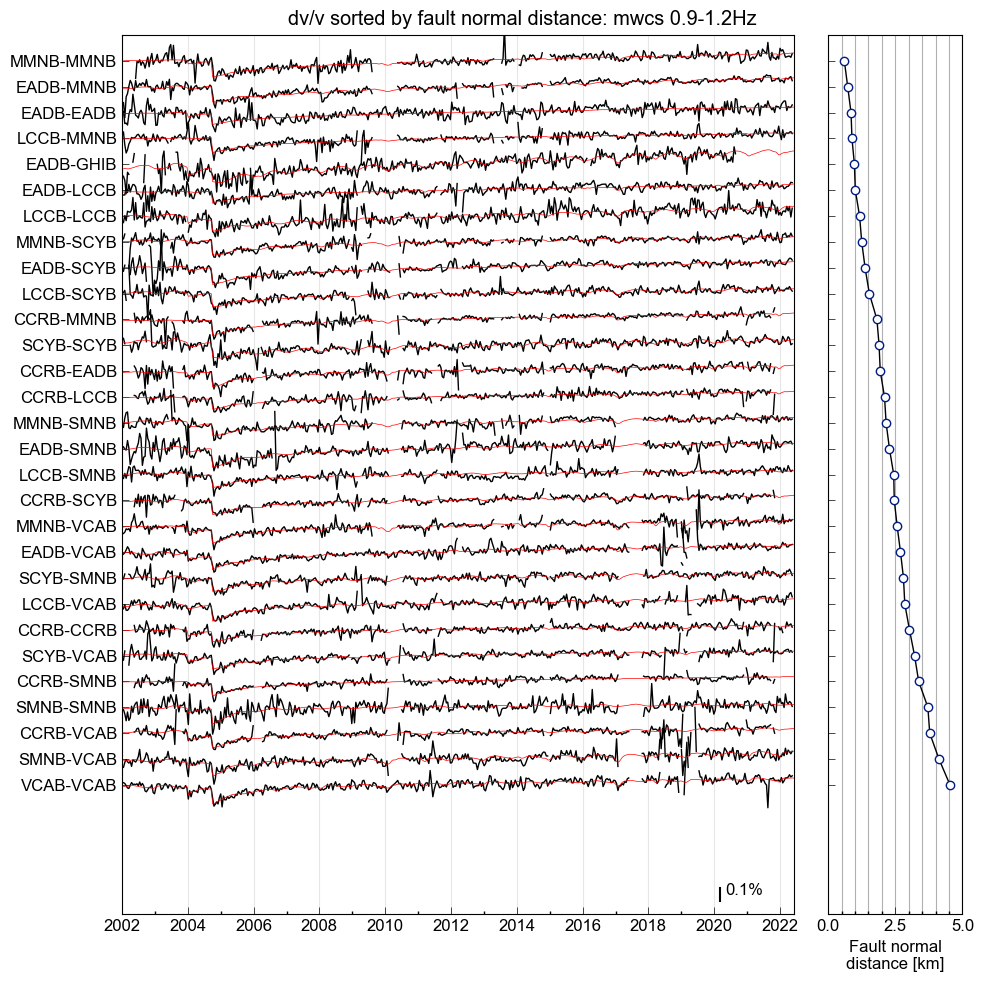

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10,10), gridspec_kw=dict(width_ratios=[1, 0.2]), sharey=True)

dvvmodel_IsOffsetRemoval = True
shift_y = 0.2
tSS = datetime.datetime(2003, 12, 22) # time for San Simeon
offset_ind = range(len(meta_dict["uniform_tvec"]))#np.where(np.array(meta_dict["uniform_tvec"]) < tSS)

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

ylimit=[-6.6, 0.2]

#--------------------------------#
# First half pairs
#--------------------------------#
mNCCF = 37-NACF

# plot sorted station pair
label_yticks_1 = []
label_yticklabels_1 = []
dist_all=[]

for i, st in enumerate(stationpairs_dict['station_all'][:]):
    try:
        dvv_data = dvv_dict[st+"/dvv_data"]
    except:
        continue
        
    dvv_model = dvv_dict[st+"/dvv_model"]

#     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
    if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:
        ls = ":"
    else:
        ls = "-"
    
    # remove offset
    if dvvmodel_IsOffsetRemoval:
        offset_data = np.nanmean(dvv_data[offset_ind])
        offset_model = np.nanmean(dvv_model[offset_ind])
        diff_offset = offset_model-offset_data
        dvv_data = dvv_data - offset_data
        dvv_model = dvv_model - offset_data #np.nanmean(dvv_model[offset_ind])    

    axs[0].plot(meta_dict["uniform_tvec"], dvv_data - i*shift_y, "k-", lw=1.0)
    axs[0].plot(meta_dict["uniform_tvec"], dvv_model - i*shift_y, "r", lw=0.5, ls=ls)
#     axs[0].axhline(-i*shift_y, c="k", ls="--", lw=1.0, zorder=-10)
#     axs[0].axhline(-i*shift_y + diff_offset, c="r", ls=":", lw=1.5, zorder=-10)

    label_yticks_1.append(- i*shift_y)
    # reformat the string
    netsta1, netsta2 = st.split("-")
    _, sta1 = netsta1.split('.')
    _, sta2 = netsta2.split('.')
    label_yticklabels_1.append(f"{sta1}-{sta2}")
    dist_all.append(pairdist_dict['pairdist'].loc[st])

# #--------------------------------#
# # second half pairs
# #--------------------------------#
# label_yticks_2 = []
# label_yticklabels_2 = []
# for i, st in enumerate(stationpairs_dict['station_all'][mNCCF:]):
#     try:
#         dvv_data = dvv_dict[st+"/dvv_data"]
#     except:
#         continue;
        
#     dvv_model = dvv_dict[st+"/dvv_model"]
    
# #     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
#     if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:
#         ls = ":"
#     else:
#         ls = "-"
    
#     # remove offset
#     if dvvmodel_IsOffsetRemoval:
#         offset_data = np.nanmean(dvv_data[offset_ind])
#         offset_model = np.nanmean(dvv_model[offset_ind])
#         diff_offset = offset_model-offset_data 
#         dvv_data = dvv_data - offset_data #np.nanmean(dvv_data[offset_ind])    
#         dvv_model = dvv_model - offset_data #np.nanmean(dvv_model[offset_ind])    

#     axs[1].plot(meta_dict["uniform_tvec"], dvv_data - (i+0)*shift_y, "k-", lw=1.0)
#     axs[1].plot(meta_dict["uniform_tvec"], dvv_model - (i+0)*shift_y, "r", lw=1.0, ls=ls)
# #     axs[1].axhline(-(i+0)*shift_y, c="k", ls="--", lw=1.0, zorder=-10)
# #     axs[1].axhline(-i*shift_y + diff_offset, c="r", ls=":", lw=1.5, zorder=-10)

#     label_yticks_2.append(-(i+0)*shift_y)
#     # reformat the string
#     netsta1, netsta2 = st.split("-")
#     _, sta1 = netsta1.split('.')
#     _, sta2 = netsta2.split('.')
#     label_yticklabels_2.append(f"{sta1}-{sta2}")

axs[0].minorticks_off()
axs[0].set_yticks(label_yticks_1, labels=label_yticklabels_1)
# axs[0].set_yticklabels(label_yticklabels_1)
axs[0].xaxis.set_major_locator(mdates.YearLocator(2))
axs[0].xaxis.set_minor_locator(mdates.YearLocator(1))
axs[0].set_xlim(starttime, endtime)
axs[0].grid(True, which='major', axis='x', c="0.9")
axs[0].set_ylim(ylimit)

# Plot averaged fault normal distance

axs[1].plot(dist_all, label_yticks_1, "o-", c="k", markeredgecolor=cpalette[0], lw=1.0, markerfacecolor="w")
axs[1].set_xlim([0, 5])
axs[1].set_xlabel("Fault normal\ndistance [km]")
axs[1].set_yticks(label_yticks_1, )
axs[1].grid(True, which="both", axis="x")

# axs[1].minorticks_off()
# axs[1].set_yticks(label_yticks_2, labels=label_yticklabels_2)
# # axs[1].set_yticklabels(label_yticklabels_2)
# axs[1].xaxis.set_major_locator(mdates.YearLocator(2))
# axs[1].xaxis.set_minor_locator(mdates.YearLocator(1))
# axs[1].set_xlim(starttime, endtime)
# axs[1].grid(True, which='major', axis='x', c="0.9")
# axs[1].set_ylim(ylimit)


fig.tight_layout()
fig.align_labels();


# plot scale
scale_x=datetime.datetime(2020,3,1)
scale_y = -6.5
scale_size = 0.1 #[%]

for i in range(1):
    axs[i].plot([scale_x, scale_x], [scale_y, scale_y + scale_size], ls ="-", c="k" )
    axs[i].text(scale_x+datetime.timedelta(days=60), scale_y + 0.5*scale_size, f"{scale_size}%", c="k" )

fig.suptitle(f'dv/v sorted by fault normal distance: {dvvmethod} {freqband}Hz', x=0.53)
fig.tight_layout(rect=[0,0,1,1.01])
# plt.subplots_adjust(hspace=0.28)
fig.align_ylabels()

foname = (output_imgdir+"/MCMC_sorteddvv_by_faultnormaldistance_{}_{}_{}.png".format(dvvmethod, freqband, modelcase))
plt.savefig(foname, dpi=300)

In [20]:
dist_all

[0.6038929576080027,
 0.7281076581678558,
 0.8523223587277089,
 0.8872496431832431,
 0.9781489083592433,
 1.0114643437430964,
 1.1706063287584836,
 1.2505422953264402,
 1.3747569958862933,
 1.5338989809016805,
 1.8158047585445298,
 1.8971916330448777,
 1.940019459104383,
 2.0991614441197703,
 2.15859965225887,
 2.2828143528187232,
 2.4419563378341107,
 2.4624540962629675,
 2.569847567449941,
 2.694062268009794,
 2.805248989977308,
 2.8532042530251815,
 3.027716559481057,
 3.2164969051683787,
 3.3705114531953972,
 3.7133063469097376,
 3.781759368386468,
 4.124554262100808,
 4.535802177291879]

In [21]:
label_yticks_1

[0.0,
 -0.2,
 -0.4,
 -0.6000000000000001,
 -0.8,
 -1.0,
 -1.2000000000000002,
 -1.4000000000000001,
 -1.6,
 -1.8,
 -2.0,
 -2.2,
 -2.4000000000000004,
 -2.6,
 -2.8000000000000003,
 -3.0,
 -3.2,
 -3.4000000000000004,
 -3.6,
 -3.8000000000000003,
 -4.0,
 -4.2,
 -4.4,
 -4.6000000000000005,
 -4.800000000000001,
 -5.0,
 -5.2,
 -5.4,
 -5.6000000000000005]